In [1]:
from pptx import Presentation

In [2]:
pptx_path = "TestFiles/test.pptx"
prs = Presentation(pptx_path)

In [3]:
def extract_node_boxes(slide, slide_num):
    """
    Extract all text boxes from a single slide and sort by position.
    Also identifies the Name (ID) of the slide as the topmost-leftmost text.
    
    Args:
        slide: The slide object from pptx.
        slide_num (int): The slide number.

    Returns:
        tuple: (List of node_boxes, Name of the slide)
    """
    node_boxes = []
    respondent = None # Store the name
    
    def extract_text_from_shape(shape, slide_num):
        """Recursively extract text from shapes, including grouped shapes."""
        if shape.has_text_frame:
            text = shape.text.strip()
            if text:
                top, left, right, bottom = shape.top, shape.left, shape.left + shape.width, shape.top + shape.height
                node_boxes.append((slide_num, top, left, right, bottom, text))

        # Handle GroupShape elements (shapes that contain other shapes)
        if shape.shape_type == 6:  # MSO_SHAPE.GROUP
            for sub_shape in shape.shapes:
                extract_text_from_shape(sub_shape, slide_num)
    
    # Extract text from all shapes on the slide
    for shape in slide.shapes:
        extract_text_from_shape(shape, slide_num)

    # Identify the name (ID) → The topmost-leftmost text box
    if node_boxes:
        name_box = min(node_boxes, key=lambda x: (x[1], x[2]))  # Sort by top, then left by (slide_num, shape.top, shape.left, text)
        if not name_box:  # Ensure name_box is not None
            return None
        respondent = name_box[5]  # Extract the text as the slide name
        node_boxes.remove(name_box)  # Remove name from nodes to avoid duplication
    
    # Count valid text nodes (after removing respondent)
    node_count = len(node_boxes)
    
    # Sort nodes by (slide number, vertical position, horizontal position)
    node_boxes.sort(key=lambda x: (x[0], x[1], x[2]))

    return node_boxes, respondent, node_count

In [4]:
# Run the function to extract text boxes and respondents from each slide
all_nodes = []  # Store all text boxes from all slides
resps = {}  # Store the respondent (top-leftmost text) for each slide

# Iterate through all slides in the PowerPoint presentation
for slide_num, slide in enumerate(prs.slides, start=1):
    # Extract text boxes (nodes) and the respondent (title/ID) from the current slide
    
    node_boxes, respondent, node_count = extract_node_boxes(slide, slide_num)  # Now safe to unpack
    
    if not respondent:
        continue
        
    # Store extracted text boxes for further processing
    all_nodes.extend(node_boxes)
    
    # Store the respondent name for this slide
    resps[slide_num] = respondent  
    
    # Print the respondent name (top-leftmost text of the slide)
    print(f"Respondent: {respondent} has {node_count} values")
    
    # Print all extracted text boxes for the current slide
    for slide_num, top, left, right, bottom, text in node_boxes:
        print(f"Slide {slide_num}: {text} - top={top}, left={left}, right={right}, bottom={bottom}")

Respondent: Bleecker Alexander has 8 values
Slide 1: Serenity - top=295321, left=1123044, right=2009063, bottom=427306
Slide 1: General LoveFriend + Romantic - top=594001, left=1702183, right=2559753, bottom=778381
Slide 1: Humor - top=611780, left=582506, right=1440076, bottom=743765
Slide 1: Intellectualism - top=925142, left=582508, right=1440078, bottom=1057127
Slide 1: Make a Difference - top=925145, left=1702184, right=2559754, bottom=1057130
Slide 1: Accomplishment - top=1185064, left=582508, right=1440078, bottom=1317049
Slide 1: Organization - top=1185064, left=1702184, right=2559754, bottom=1317049
Slide 1: Discipline - top=1484708, left=1142346, right=1999916, bottom=1616693
Respondent: Bleecker Alexander has 8 values
Slide 2: Serenity - top=295321, left=1123044, right=2009063, bottom=427306
Slide 2: General LoveFriend + Romantic - top=594001, left=1702183, right=2559753, bottom=778381
Slide 2: Humor - top=611780, left=582506, right=1440076, bottom=743765
Slide 2: Intellec

# Plotting for check

## Adjusted & Inverse Y Coordinator

In [5]:
import matplotlib.pyplot as plt
from matplotlib import patches

In [6]:
from LinesExtraction import extract_lines

/var/folders/pj/csflcfl13v78mjmgbc3k8k3r0000gn/T/ipykernel_59982/1511837602.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(lines))  # Use a colormap with distinct colors
/Users/jiazhengtian/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


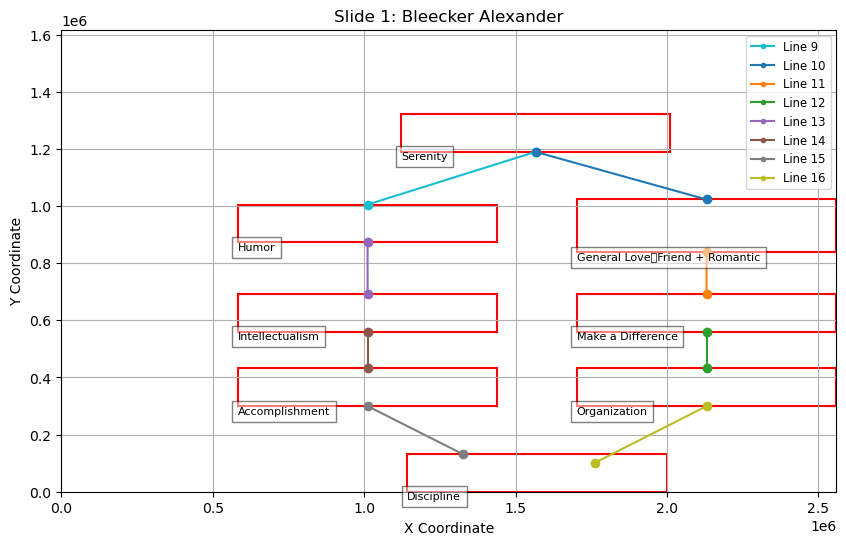

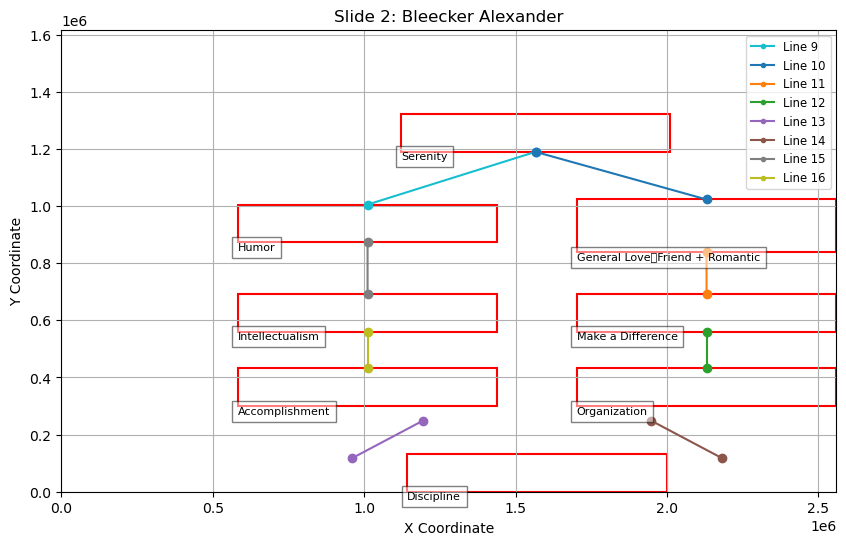

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


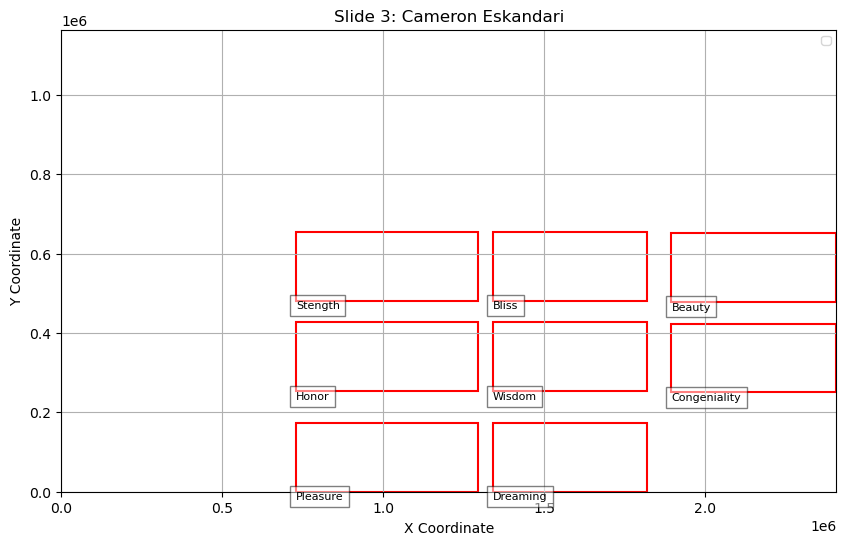

In [7]:
def plot_boxes_and_lines_from_pptx(prs):
    """
    Plots all extracted text boxes and lines from the PPTX file to verify correct extraction.

    Args:
        prs: The PowerPoint presentation object.
    """
    for slide_num, slide in enumerate(prs.slides, start=1):
        # Extract text boxes
        node_boxes, respondent, node_count = extract_node_boxes(slide, slide_num)
        # Extract lines
        lines, line_count = extract_lines(slide)  # Your function for extracting line positions

        if not node_boxes and not lines:
            continue  # Skip slide if there are no boxes or lines

        # Compute maximum Y-value (slide height reference)
        max_y = max([bottom for _, _, _, _, bottom, _ in node_boxes] + 
                    [max(y1, y2) for _, (x1, y1, x2, y2) in lines.items()], 
                    default=1000)

        # Create figure
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

        # Compute maximum X-value (slide width reference)
        max_x = max([right for _, _, _, right, _, _ in node_boxes] + 
                    [max(x1, x2) for _, (x1, _, x2, _) in lines.items()], 
                    default=1000)
        
        ax.set_xlim(0, max_x + 100)  # Expand X-axis range
        ax.set_ylim(0, max_y + 100)  # Adjust Y-axis to fit all elements
        ax.set_title(f"Slide {slide_num}: {respondent}" if respondent else f"Slide {slide_num}")
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")

        # Draw text boxes
        for box in node_boxes:
            _, top, left, right, bottom, text = box
            width = right - left
            height = bottom - top

            # Adjust Y coordinate (convert PPT bottom to Matplotlib top)
            new_top = max_y - bottom  

            # Draw rectangle around the text box
            rect = patches.Rectangle((left, new_top), width, height, edgecolor='red', facecolor='none', linewidth=1.5)
            ax.add_patch(rect)

            # Add text inside the box
            ax.text(left + 5, new_top + 15, text, fontsize=8, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.5))

        # Generate a unique color for each line
        colors = plt.cm.get_cmap("tab10", len(lines))  # Use a colormap with distinct colors

        # Draw lines with unique colors
        for line_id, (x1, y1, x2, y2) in lines.items():
            # Adjust Y coordinates to match Matplotlib format
            new_y1 = max_y - y1
            new_y2 = max_y - y2

            # Assign a unique color for each line
            color = colors(line_id % 10)  # Limit color index within colormap range

            # Plot the line with a unique color
            plt.plot([x1, x2], [new_y1, new_y2], marker="o", linestyle="-", color=color, label=f"Line {line_id}")

        plt.grid(True)
        plt.legend(loc="best", fontsize="small", markerscale=0.5)  # Add legend
        plt.show()

# Run function to visualize extracted text boxes and lines
plot_boxes_and_lines_from_pptx(prs)